<i><b>Public AI</b></i>
<br>
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 1. OpenCV Basis**
# Section 3. 영상의 기하학 처리(1) Mapping과 RST변환

영상 처리에서 기하학 처리는 영상 내에 있는 기하학적인 대상의 공간적 배치를 변경하는 과정입니다. 이것을 픽셀의 입장에서 보면, 영상을 구성하는 픽셀들의 공간적 위치를 재배치하는 과정이다. 이러한 재배치를 담당하는 함수를 **mapping** 함수라 하고, 모든 기하학 처리는 어떤 mapping 함수를 이용하는 가에 따라 달라집니다.

### _Objective_
1. **Mapping** : 영상의 기하학적 처리를 위해 mapping과 양방향 선형보간법에 대해 알아봅니다. <br>
2. **RST 변환** : 기하학 처리에서의 3대 변환인 RST변환에 대해 알아봅니다.

In [1]:
# 영상처리에 있어서 핵심적인 matplotlib과 opencv , numpy 가져오기
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
if not os.path.exists("len_top.jpg"):
    # 영상처리에 있어서 가장 많이 이용되는 Lena 이미지 활용하기
    !wget http://www.lenna.org/len_top.jpg

# \[ 1. Mapping\]

기하학적 처리의 기본은 픽셀들의 배치를 변경하는 것입니다. 픽셀의 배치를 변경하려면 **사상(mapping)**이라는 의미를 이해해야 합니다. 사상은 픽셀들의 배치를 변경할 때, 입력영상의 좌표가 새롭게 배치될 해당 목적영상의 좌표를 찾아서 픽셀값을 옮기는 과정입니다.

## 1. 순방향 사상

순방향 사상은 원본 영상의 좌표를 중심으로 목적영상의 좌표를 계산하여 화소의 위치를 변환하는 방식을 말합니다. 순방향 사상의 경우 **홀(hole)**과 **오버랩(overlap)** 문제가 발생할 수 있습니다. 홀은 입력영상의 좌표들로 목적 영상의 좌표를 만드는 과정에서 사상되지 않은 픽셀들을 말합니다. 보통 영상을 확대하거나 회전할 때에 발생합니다. 이와 달리 오버랩은 영상을 축소할 때 주로 발생합니다. 오버랩은 원본 영상의 여러 화소가 목적 영상의 한 화소로 사상되는 것을 말합니다. 

<img src="https://i.imgur.com/VB8Gs7r.png" width="600" height="450"/>

### 예제 1) 순방향 사상을 통해 이미지를 2배로 키워보기

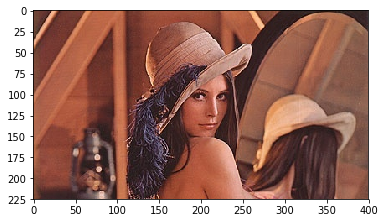

In [2]:
image = cv2.imread("./len_top.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

In [3]:
height,width = image.shape[:2]
target_image = np.zeros((int(height*2),int(width*2),3),np.uint8)

xs, ys = np.meshgrid(np.arange(width), np.arange(height))

for x,y in zip(xs.ravel(), ys.ravel()):
    target_y = np.clip(2*y, 0, target_image.shape[0]-1).astype(np.int)
    target_x = np.clip(2*x, 0, target_image.shape[1]-1).astype(np.int)
    
    
    target_image[target_y, target_x] = image[y,x]

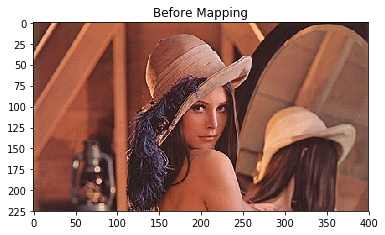

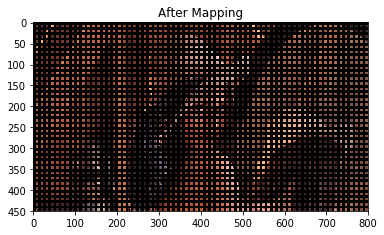

In [4]:
plt.title("Before Mapping")
plt.imshow(image)
plt.show()

plt.title("After Mapping")
plt.imshow(target_image)
plt.show()

위 이미지에서 보이는 검은 부분들이 모두 hole이라고 생각하면 됩니다. 이러한 문제 때문에 기본적으로 순방향 사상은 거의 쓰지 않는 방식입니다.

## 2. 역방향 사상

 역방향 사상은 결과 영상의 모든 픽셀을 차례대로 방문하며 해당 픽셀이 원본 영상의 어느 위치에서 사상되었는지 생각하는 방식을 말합니다. 역방향 사상의 경우 목적영상의 좌표를 중심으로 역변환을 계산하여 해당하는 입력 영상의 좌표를 찾아서 픽셀 값을 가져오기 때문에 홀이나 오버랩은 발생하지 않습니다.

<img src="https://i.imgur.com/ASxZwNl.png" width="600" height="450"/>

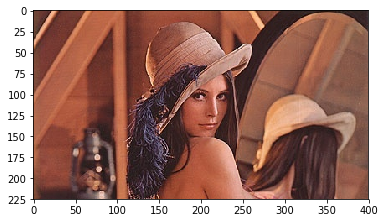

In [5]:
image = cv2.imread("./len_top.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

### 예제 2) 역방향 사상을 통해 이미지를 2배로 키워보기

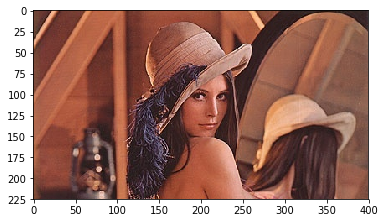

In [6]:
image = cv2.imread("./len_top.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

In [7]:
height,width = image.shape[:2]
target_image = np.zeros((int(height*2),int(width*2),3),np.uint8)
t_height, t_width = target_image.shape[:2]

xs, ys = np.meshgrid(np.arange(t_width), np.arange(t_height))

for target_x, target_y in zip(xs.ravel(), ys.ravel()):
    origin_y = np.clip(target_y/2, 0, height-1).astype(np.int)
    origin_x = np.clip(target_x/2, 0, width-1).astype(np.int)
    
    target_image[target_y, target_x] = image[origin_y,origin_x]

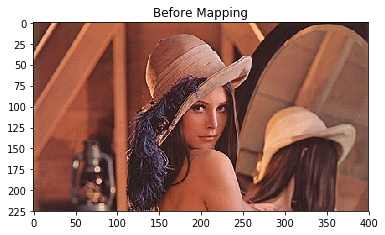

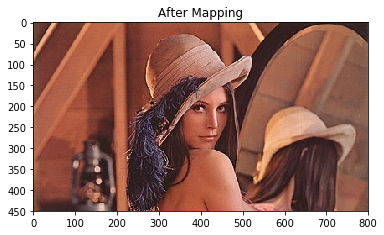

In [8]:
plt.title("Before Mapping")
plt.imshow(image)
plt.show()

plt.title("After Mapping")
plt.imshow(target_image)
plt.show()

## 3. 양방향 선형보간법(Bilinear Interpolation)

위와 같이 역방향 사상이 순방향 사상보다 기본적으로 깔끔한 방식입니다. 홀이나 오버랩이 기본적으로 발생하지 않기 떄문에 훨씬 더 부드럽게 진행됩니다. 그러나 입력영상의 한 화소를 목적영상의 여러 화소에서 사용하게 되면 아래와 같이 계단식의 형상이 만들어져 결과 영상의 품질이 떨어질 수 있습니다. 이 문제를 극단적으로 보기 위해 영상의 크기를 5배로 키워보겠습니다.

### 예제 3) 역방향 사상을 통해 이미지를 5배로 키워보기

In [9]:
# 시간이 너무 많이 걸리므로 일부 이미지만 crop해서 하겠음
crop_image = image[50:150,150:250]

height,width = crop_image.shape[:2]
target_image = np.zeros((int(height*5),int(width*5),3),np.uint8)
t_height, t_width = target_image.shape[:2]

xs, ys = np.meshgrid(np.arange(t_width), np.arange(t_height))

for target_x, target_y in zip(xs.ravel(), ys.ravel()):
    origin_y = np.clip(target_y/5, 0, height-1).astype(np.int)
    origin_x = np.clip(target_x/5, 0, width-1).astype(np.int)
    
    target_image[target_y, target_x] = crop_image[origin_y,origin_x]

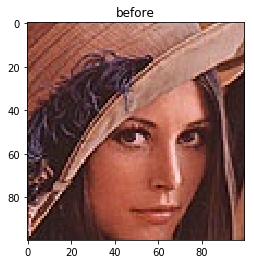

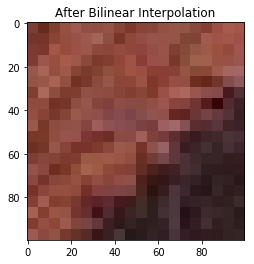

In [10]:
plt.title("before")
plt.imshow(crop_image)
plt.show()

plt.title("After Bilinear Interpolation")
plt.imshow(target_image[100:200,0:100])
plt.show()

자세히 보면 이미지가 모자이크 형태처럼 5x5 블럭끼리 완전히 같은 색깔을 가지고 있습니다. 이것을 보다 부드럽게 보정하기 위해 **양선형 보간법(Bilinear Interpolation)**을 이용해보겠습니다. 양선형 보간법은 위와 같이, 선형 보간을 두 번에 걸쳐서 수행하기에 붙여진 이름입니다. x축을 기준으로 한번, y축을 기준으로 또 한번 보간함으로써 값을 보정합니다. 이를 아래 이미지와 함께 더 자세히 알아보겠습니다.

<img src="https://i.imgur.com/Aue9vUx.png" width="800" height="600"/>

먼저, 목적영상의 화소(P)를 역변환으로 계산하여 가장 가까운 위치에 있는 입력 영상의 4개 화소(A,B,C,D)를 가져옵니다. 그림과 같이 가져온 4개 화소를 두 개씩(AB,CD) 묶어서 1차적으로 선형 보간(M1,M2)을 진행합니다. 그리고 M1,M2을 잇는 직선을 다시 구성하고, 두개의 중간 화소값과 거리 비율($\beta$,$1-\beta$)을 바탕으로 선형보간을 통해 최종 화소값(P)를 계산하는 방식입니다. 

### 예제 4) 양방향 선형 보간법 사상을 통해, 이미지를 5배로 키워보기

In [11]:
# 시간이 너무 많이 걸리므로 일부 이미지만 crop해서 하겠음
crop_image = image[50:150,150:250]

height,width = crop_image.shape[:2]
target_image = np.zeros((int(height*5),int(width*5),3),np.uint8)
t_height, t_width = target_image.shape[:2]

xs, ys = np.meshgrid(np.arange(t_width), np.arange(t_height))

for target_x, target_y in zip(xs.ravel(), ys.ravel()):
    origin_x = target_x/5
    origin_y = target_y/5
    
    min_x = np.floor(origin_x).astype(np.int)
    min_y = np.floor(origin_y).astype(np.int)
    max_x = np.ceil(origin_x).astype(np.int)
    max_y = np.ceil(origin_y).astype(np.int)

    alpha = origin_x - min_x
    beta = origin_y - min_y
    
    if max_x >= width: max_x = width-1
    if max_y >= height: max_y = height-1

    A = crop_image[min_y,min_x].astype(np.float)
    B = crop_image[min_y,max_x].astype(np.float)
    C = crop_image[max_y,min_x].astype(np.float)
    D = crop_image[max_y,max_x].astype(np.float)
    
    M1 = A + alpha*(B-A)
    M2 = C + alpha*(D-C)
    P = M1 + beta*(M2-M1)
    
    target_image[target_y, target_x] = P.astype(np.uint8)

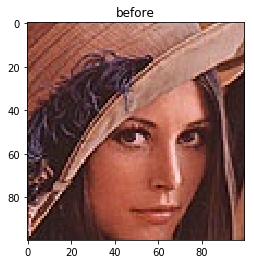

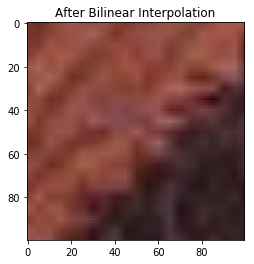

In [12]:
plt.title("before")
plt.imshow(crop_image)
plt.show()

plt.title("After Bilinear Interpolation")
plt.imshow(target_image[100:200,0:100])
plt.show()

모자이크 현상이 사라지고, 훨씬 더 부드럽게 선이 이어집니다. 하지만, 이렇게 구현된 경우에(For 구문) 처리 속도가 굉장히 느립니다. 그래서 일반적으로 우리가 이미지를 resize할 때, OpenCv의 `cv2.resize` 메소드를 이용합니다.

## 4. `cv2.resize`

기본적으로 OpenCV에는 이미지의 확대 및 축소를 해주는 `cv2.resize` 메소드가 구현되어 있습니다. 이는 아래와 같이 동작합다.

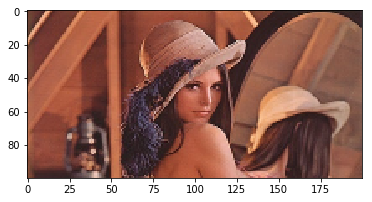

In [13]:
target_height = 100 # 높이를 100 pixel로
target_width = 200 # 가로를 200 pixel로

target = cv2.resize(image,(target_width,target_height))

plt.imshow(target)
plt.show()

이렇게 목표 영상의 크기를 지정할 수 있고, 아래와 같이 배율을 지정할 수도 있습니다.

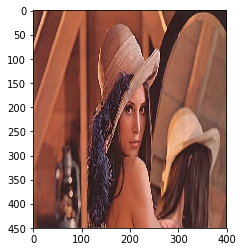

In [14]:
target = cv2.resize(image,None,fx=1.0,fy=2.)

plt.imshow(target)
plt.show()

# \[ 2. RST 변환\]

**RST 변환**이란 Rotation, Scaling, Translation의 기하학 처리에서 3대 변환이라 불리는 변환을 말합니다. 영상의 기하학적 변환에는 이미지의 크기 변환, 평행 이동, 회전등을 가능하게 하는 변환으로 **아핀 변환(Affine Transformation)**과 **원근 변환(Perspective Transforamtion)**이 있습니다. 아핀 변환은 2X3 matrix를 사용하여 행렬 곱셈에 벡터 합을 활용하는 변환을 말하고, 원근 변환은 3X3 matrix를 사용합니다. 수업시간에는 영상에서의 RST 변환을 아핀 변환과 연결지어 알아보겠습니다.

## 1. Affine 변환이란?

영상의 기하학적 변환 중 아핀 변환은 영상을 평행이동시키거나 회전, 크기 변환등을 통해 만들 수 있는 변환을 통칭합니다. 영상에 아핀 변환을 적용할 경우, 직선은 그대로 직선으로 나타나고, 직선간의 길이 비율과 평행관계는 그대로 유지됩니다. 직사각형 형태의 이미지에 아핀 변환을 적용하면 평행사변형의 이미지로 변환됩니다.

$$
\begin{pmatrix} x' \\ y' \\ 1 \end{pmatrix} = \begin{pmatrix} a_{00} & a_{01} & b_0 \\ a_{10} & a_{11} & b_1 \\ 0 & 0 & 1 \end{pmatrix} \begin{pmatrix} x \\ y \\ 1 \end{pmatrix}\\
\begin{pmatrix} x' \\ y' \\ 1 \end{pmatrix} = \begin{pmatrix} a_{00}x_1 + a_{01}y_1 + b_0 \\ a_{10}x_1 + a_{11}y_1 + b_1 \\ 0 + 0 + 1 \end{pmatrix}
$$

위 행렬은 아핀 변환 행렬의 기본형입니다. 아핀 변환 행렬의 기본형은 3X3 행렬이지만 세번째 행의 값은 0, 0, 1의 값을 가집니다. 좌변의 행렬과 우변의 행렬의 세번째 행의 값은 항상 같은 값을 지니므로 OpenCv에서는 불필요한 연산을 줄이기 위해 2X3 행렬로 표현합니다. $x_1$, $y_1$은 변환 전 원본 이미지의 픽셀 좌표를 의미 하며, $x_2$, $y_2$는 변환 후의 픽셀 좌표를 의미합니다.

<img src="https://i.imgur.com/xQ4f3T0.png" width="800" height="600"/>

변환 후의 픽셀 좌표를 계산하기 위해서는 $a_{00}$, $a_{01}$, $a_{10}$, $a_{11}$, $b_{0}$, $b_{1}$의 값을 알아야합니다. 6개의 미지수를 구하기 위해 아핀 변환에서는 3개의 좌표를 활용해 미지수를 계산합니다. 위 이미지에서는 임의 위치인 A, B, C 3개의 픽셀 좌표를 A', B', C'으로 이동한 좌표를 사용해 6개의 미지수를 구한 후 아핀 변환 행렬을 계산한것입니다.

## 2. Scaling

이미지의 사이즈를 변화시키는 Scaling 부분은 일전에도 다루었듯이 `cv2.resize`를 통해서도 쉽게 구현이 가능했습니다.

$$
X' = X * ratio_x,~Y' = Y * ratio_y
$$

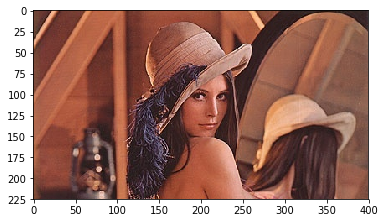

In [15]:
image = cv2.imread("./len_top.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

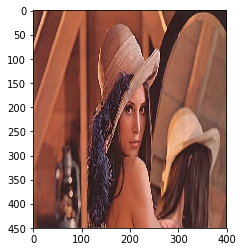

In [16]:
target = cv2.resize(image,None,fx=1.0,fy=2.)

plt.imshow(target)
plt.show()

Scaling 과정을 좀 더 이론적으로 접근한다면, 위의 수식을 아래의 아핀 변환 행렬로 풀어볼 수 있습니다.

$$
\begin{pmatrix} x' \\ y' \\ t' \end{pmatrix} = \begin{pmatrix} ratio_x & 0 & 0 \\ 0 & ratio_y & 0 \end{pmatrix} \begin{pmatrix} x \\ y \\ 1 \end{pmatrix}
$$

Opencv에서는 Affine Matrix를 넣으면 알아서 Mapping하고 bilinear interpolation까지 적용하는 함수가 존재합니다.

`cv2.warpAffine(src,M,dsize)`
* src - Image
* M - 변환행렬
* dsize(tuple) - output image size(width=columns, height=rows)

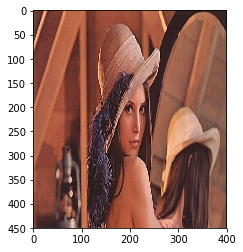

In [17]:
affine_matrix = np.array([
    [1.0,0,  0 ],
    [0  ,2.0,0 ]])

height, width = image.shape[:2]
target_height = height * 2
target_width = width


target = cv2.warpAffine(image, affine_matrix, 
                        (target_width,target_height) )

plt.imshow(target)
plt.show()

## 3. Translation

RST에서 T는 Translation으로 직관적으로 이해하기 쉬운 평행 이동 변환입니다. Translation 과정에서의 아핀 변환 행렬은 아래와 같습니다.

$$
\begin{pmatrix} x' \\ y' \\ t' \end{pmatrix} = \begin{pmatrix} 1 & 0 & t_x \\ 0 & 1 & t_y \end{pmatrix} \begin{pmatrix} x \\ y \\ 1 \end{pmatrix}
$$

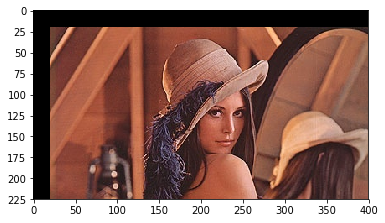

In [18]:
affine_matrix = np.array([
    [1.0,0,  20 ],
    [0  ,1.0,20 ]])

height, width = image.shape[:2]
target_height = height
target_width = width

target = cv2.warpAffine(image, affine_matrix, 
                        (target_width,target_height) )

plt.imshow(target)
plt.show()

## 4. Rotation

RST의 R은 이미지를 회전시키는 Rotation 변환입니다.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d6/DistanceFromAtoB_Matrix_Rota.svg/600px-DistanceFromAtoB_Matrix_Rota.svg.png" width="400" height="300"/>

$$
\begin{pmatrix} x' \\ y' \\ t' \end{pmatrix} = \begin{pmatrix} cos\theta & -sin\theta & 0 \\ sin\theta & cos\theta & 0 \end{pmatrix} \begin{pmatrix} x \\ y \\ 1 \end{pmatrix}
$$

위의 이미지를 보면, $(x,y)$가 $\theta$만큼 회전하기 위한 아핀 변환 행렬은 위의 행렬과 같습니다. 위의 수식을 바탕으로 원본 이미지를 30도만큼 회전시켜보겠습니다.

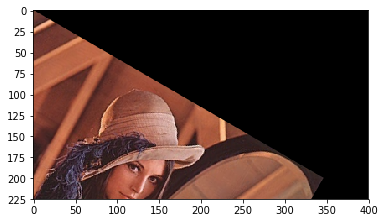

In [19]:
affine_matrix = np.array([
    [np.cos(np.pi/6),-np.sin(np.pi/6),0 ],
    [np.sin(np.pi/6),np.cos(np.pi/6),0 ]])

height, width = image.shape[:2]
target_height = height
target_width = width

target = cv2.warpAffine(image, affine_matrix, 
                        (target_width,target_height) )

plt.imshow(target)
plt.show()

30도만큼 움직였는데, 이미지의 중심이 아닌 원점을 중심으로 회전해버렸습니다. 원점을 중심으로 이미지를 회전시키려면 어떻게 해야 할까요? 바로 Translation 과정을 먼저 거친 후에, 그 후 affine matrix로 회전시키고, 다시 Translation 과정을 통해 이미지의 위치를 복구 해야합니다. 

$$
R(\theta) = \begin{pmatrix} cos\theta & -sin\theta & 0 \\ sin\theta & cos\theta & 0 \end{pmatrix}
$$

$$
T(T_x,T_y) = \begin{pmatrix} 1 & 0 & T_x \\ 0 & 1 & T_y \end{pmatrix}
$$

$$
T(center_x,center_y) * R * T(-center_x,-center_y) = 
\begin{pmatrix} cos\theta & -sin\theta & -T_xcos\theta + T_x+T_ysin\theta \\ sin\theta & cos\theta & -T_xsin\theta - T_ycos\theta + T_y \end{pmatrix}
$$

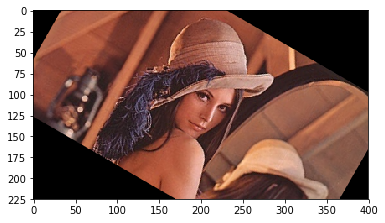

In [20]:
height, width = image.shape[:2]
c_y = height//2
c_x = width//2

theta = np.pi/6

affine_matrix = np.array([
    [np.cos(theta),-np.sin(theta),-c_x*np.cos(theta)+c_x+c_y*np.sin(theta) ],
    [np.sin(theta),np.cos(theta),-c_x*np.sin(theta)-c_y*np.cos(theta)+c_y ]])

height, width = image.shape[:2]
target_height = height
target_width = width

target = cv2.warpAffine(image, affine_matrix, 
                        (target_width,target_height) )

plt.imshow(target)
plt.show()

<hr>

Copyright(c) 2019 by Public AI. All rights reserved. last updated on 2019/02/01<br>
Writen by PAI, SangJae Kang(rocketgrowthsj@publicai.co.kr) 
<hr>